=== Phase 3: Learning Dynamics Check ===
Device: cuda
Step   | Sinkhorn Loss   | Proposal Loss  
---------------------------------------------
0      | 1.322990          | 1.326516
50     | 0.649427          | 0.688428
100    | 0.221790          | 0.261767
150    | 0.072615          | 0.102201
200    | 0.025931          | 0.039325
250    | 0.012505          | 0.017224
300    | 0.008911          | 0.010477
350    | 0.007038          | 0.007656
400    | 0.006551          | 0.006840
450    | 0.006417          | 0.006545
---------------------------------------------
Total Training Time (500 steps):
  Sinkhorn: 4.31 sec
  Proposal: 1.71 sec
  Ratio   : 2.53x faster


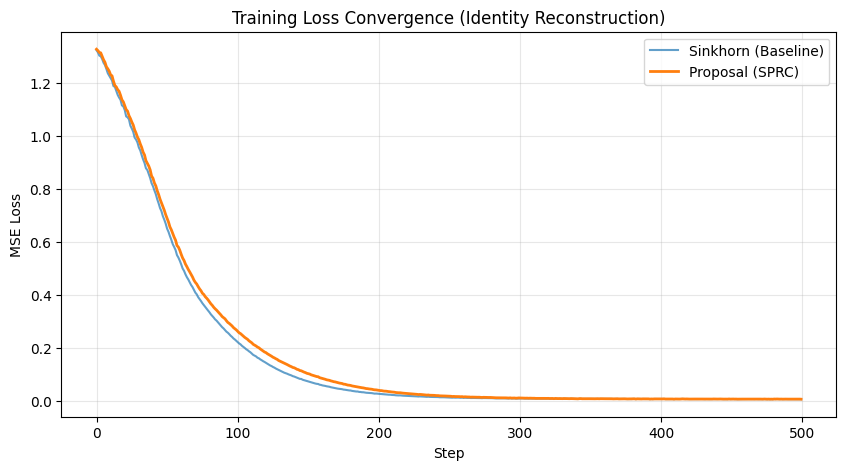

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time
import numpy as np

# === 1. 実装（修正済み） ===

def stabilized_rational_chart(u, epsilon=1e-6, lambd=0.1):
    # 提案手法 (SPRC)
    # 修正: shapeのアンパックをやめ、Batchサイズだけ安全に取得
    B = u.shape[0]
    u = u.view(B, 3, 3) # (B, 9) -> (B, 3, 3)

    row_sum = u.sum(dim=2, keepdim=True)
    col_sum = u.sum(dim=1, keepdim=True)
    total_sum = row_sum.sum(dim=1, keepdim=True)

    top = torch.cat([u, -row_sum], dim=2)
    bot = torch.cat([-col_sum, total_sum], dim=2)
    V = torch.cat([top, bot], dim=1)

    m_V = F.relu(torch.max(-V.view(B, 16), dim=1)[0].view(B, 1, 1))
    norm_V1 = torch.sum(torch.abs(V), dim=(1, 2), keepdim=True)
    denominator = m_V + epsilon + lambd * norm_V1

    H = 0.25 + (0.25 * V) / denominator
    return H

def sinkhorn_knopp(u_raw, n_iters=20):
    # Baseline: 入力をまず正値化してからSinkhorn
    # u_raw: (B, 4, 4)
    matrix = torch.exp(u_raw) # 単純なexp
    for _ in range(n_iters):
        matrix = matrix / (matrix.sum(dim=2, keepdim=True) + 1e-6)
        matrix = matrix / (matrix.sum(dim=1, keepdim=True) + 1e-6)
    return matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

def stabilized_rational_chart_v2(u, epsilon=1e-6, lambd=1.0, smoothness=1.0):
    """
    Revised SPRC v2:
    1. Corrects the 'Inverted Saturation' bug. (Larger input -> Closer to boundary)
    2. Uses Softmax/LSE for smooth gradients (No kinks).
    """
    B = u.shape[0]
    # 1. Tangent Space Projection (O(1) linear map)
    u_3x3 = u.view(B, 3, 3)
    row_sum = u_3x3.sum(dim=2, keepdim=True)
    col_sum = u_3x3.sum(dim=1, keepdim=True)
    total_sum = row_sum.sum(dim=1, keepdim=True)

    top = torch.cat([u_3x3, -row_sum], dim=2)
    bot = torch.cat([-col_sum, total_sum], dim=2)
    V = torch.cat([top, bot], dim=1) # (B, 4, 4) zero-sum

    # 2. Smooth Tropical Norm (Distance to boundary)
    # Instead of max(-V), use LogSumExp(-V) for smoothness
    # m(V) approximates max(-V_ij)
    neg_V = -V
    # scaling factor 'smoothness' controls approximation quality (lower = closer to max)
    m_V_smooth = smoothness * torch.logsumexp(neg_V.view(B, 16) / smoothness, dim=1).view(B, 1, 1)

    # 3. Progressive Saturation (The Fix)
    # Scale: 0 (at center) -> 1 (at boundary) based on input magnitude
    # Using tanh on the Frobenius norm of V
    V_norm = torch.norm(V.view(B, 16), p=2, dim=1).view(B, 1, 1)
    saturation = torch.tanh(lambd * V_norm)

    # 4. Construct H
    # H = J + saturation * (Distance_to_Boundary * V_direction)
    # Distance_to_Boundary ~ 0.25 / m_V

    # Note: If V is all zeros, m_V might be close to 0 (or log(16)*smoothness).
    # But tanh(0) is 0, so the second term vanishes safely.

    # Stability: Add epsilon to denominator
    scale = (0.25 * saturation) / (m_V_smooth + epsilon)

    H = 0.25 + scale * V

    return H

# === 2. テスト用レイヤー定義 ===

class ToyMHCLayer(nn.Module):
    def __init__(self, dim, method='proposal'):
        super().__init__()
        self.dim = dim
        self.method = method

        # mHC用のパラメータ (n=4)
        if method == 'proposal':
            self.param = nn.Parameter(torch.randn(1, 9) * 0.1)
        else:
            self.param = nn.Parameter(torch.randn(1, 4, 4) * 0.1)

        # ダミーの線形層 (学習対象)
        self.linear = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x: (B, Seq, Dim)
        B_size = x.size(0)

        # 接続行列 H を生成 (Batchサイズに合わせて拡張)
        if self.method == 'proposal':
            u_exp = self.param.expand(B_size, -1)
            H = stabilized_rational_chart_v2(u_exp) # (B, 4, 4)
        else:
            u_exp = self.param.expand(B_size, -1, -1)
            H = sinkhorn_knopp(u_exp) # (B, 4, 4)

        # mHC的な混合操作 (簡易版)
        chunk_dim = self.dim // 4
        x_split = x.view(B_size, -1, 4, chunk_dim) # (B, S, 4, D/4)

        H = H.unsqueeze(1) # (B, 1, 4, 4)

        # Einstein Summation: batch(b), seq(s), out_mix(i), in_mix(j), dim(d)
        x_mixed = torch.einsum('b s j d, b s i j -> b s i d', x_split, H)
        x_mixed = x_mixed.reshape(B_size, -1, self.dim)

        return self.norm(x_mixed + self.linear(x))

# === 3. 学習ループ ===

def run_training_experiment():
    print("=== Phase 3: Learning Dynamics Check ===")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Device: {device}")

    # 設定
    DIM = 256
    STEPS = 500
    BATCH = 64
    LR = 1e-3

    models = {
        'Sinkhorn': ToyMHCLayer(DIM, method='sinkhorn').to(device),
        'Proposal': ToyMHCLayer(DIM, method='proposal').to(device)
    }

    optimizers = {
        name: optim.AdamW(model.parameters(), lr=LR) for name, model in models.items()
    }

    history = {'Sinkhorn': [], 'Proposal': []}
    times = {'Sinkhorn': 0.0, 'Proposal': 0.0}

    print(f"{'Step':<6} | {'Sinkhorn Loss':<15} | {'Proposal Loss':<15}")
    print("-" * 45)

    for step in range(STEPS):
        # ランダムデータ生成
        x = torch.randn(BATCH, 16, DIM, device=device)
        target = x.clone() # 入力を復元するタスク

        for name, model in models.items():
            t0 = time.time()

            optimizers[name].zero_grad()
            out = model(x)
            loss = F.mse_loss(out, target)
            loss.backward()
            optimizers[name].step()

            dt = time.time() - t0
            times[name] += dt
            history[name].append(loss.item())

            if name == 'Proposal' and step % 50 == 0:
                s_loss = history['Sinkhorn'][-1]
                p_loss = history['Proposal'][-1]
                print(f"{step:<6} | {s_loss:.6f}          | {p_loss:.6f}")

    print("-" * 45)
    print(f"Total Training Time (500 steps):")
    print(f"  Sinkhorn: {times['Sinkhorn']:.2f} sec")
    print(f"  Proposal: {times['Proposal']:.2f} sec")
    ratio = times['Sinkhorn'] / times['Proposal'] if times['Proposal'] > 0 else 0
    print(f"  Ratio   : {ratio:.2f}x faster")

    # グラフ描画
    plt.figure(figsize=(10, 5))
    plt.plot(history['Sinkhorn'], label='Sinkhorn (Baseline)', alpha=0.7)
    plt.plot(history['Proposal'], label='Proposal (SPRC)', linewidth=2)
    plt.title('Training Loss Convergence (Identity Reconstruction)')
    plt.xlabel('Step')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    run_training_experiment()